In [1]:
# Imprting Libraries
import pandas as pd
import numpy as np # linear algebra
import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization



In [2]:
df = pd.read_csv('Aquifer_Petrignano.csv')
df.head()
df.tail()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
5218,26/06/2020,0.0,-25.68,-25.07,25.7,24.5,-29930.688,2.5
5219,27/06/2020,0.0,-25.80,-25.11,26.2,25.0,-31332.960,2.4
5220,28/06/2020,0.0,-25.80,-25.19,26.9,25.7,-32120.928,2.4
5221,29/06/2020,0.0,-25.78,-25.18,26.9,26.0,-30602.880,2.4
5222,30/06/2020,0.0,-25.91,-25.25,27.3,26.5,-31878.144,2.4


In [3]:
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)

In [4]:
# Remove not usefull columns
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [5]:
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

In [6]:
targets = ['depth_to_groundwater']


In [7]:
features = [feature for feature in df.columns if feature not in targets]


In [8]:
df.head()


,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [10]:
from datetime import datetime, date 
df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})


,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


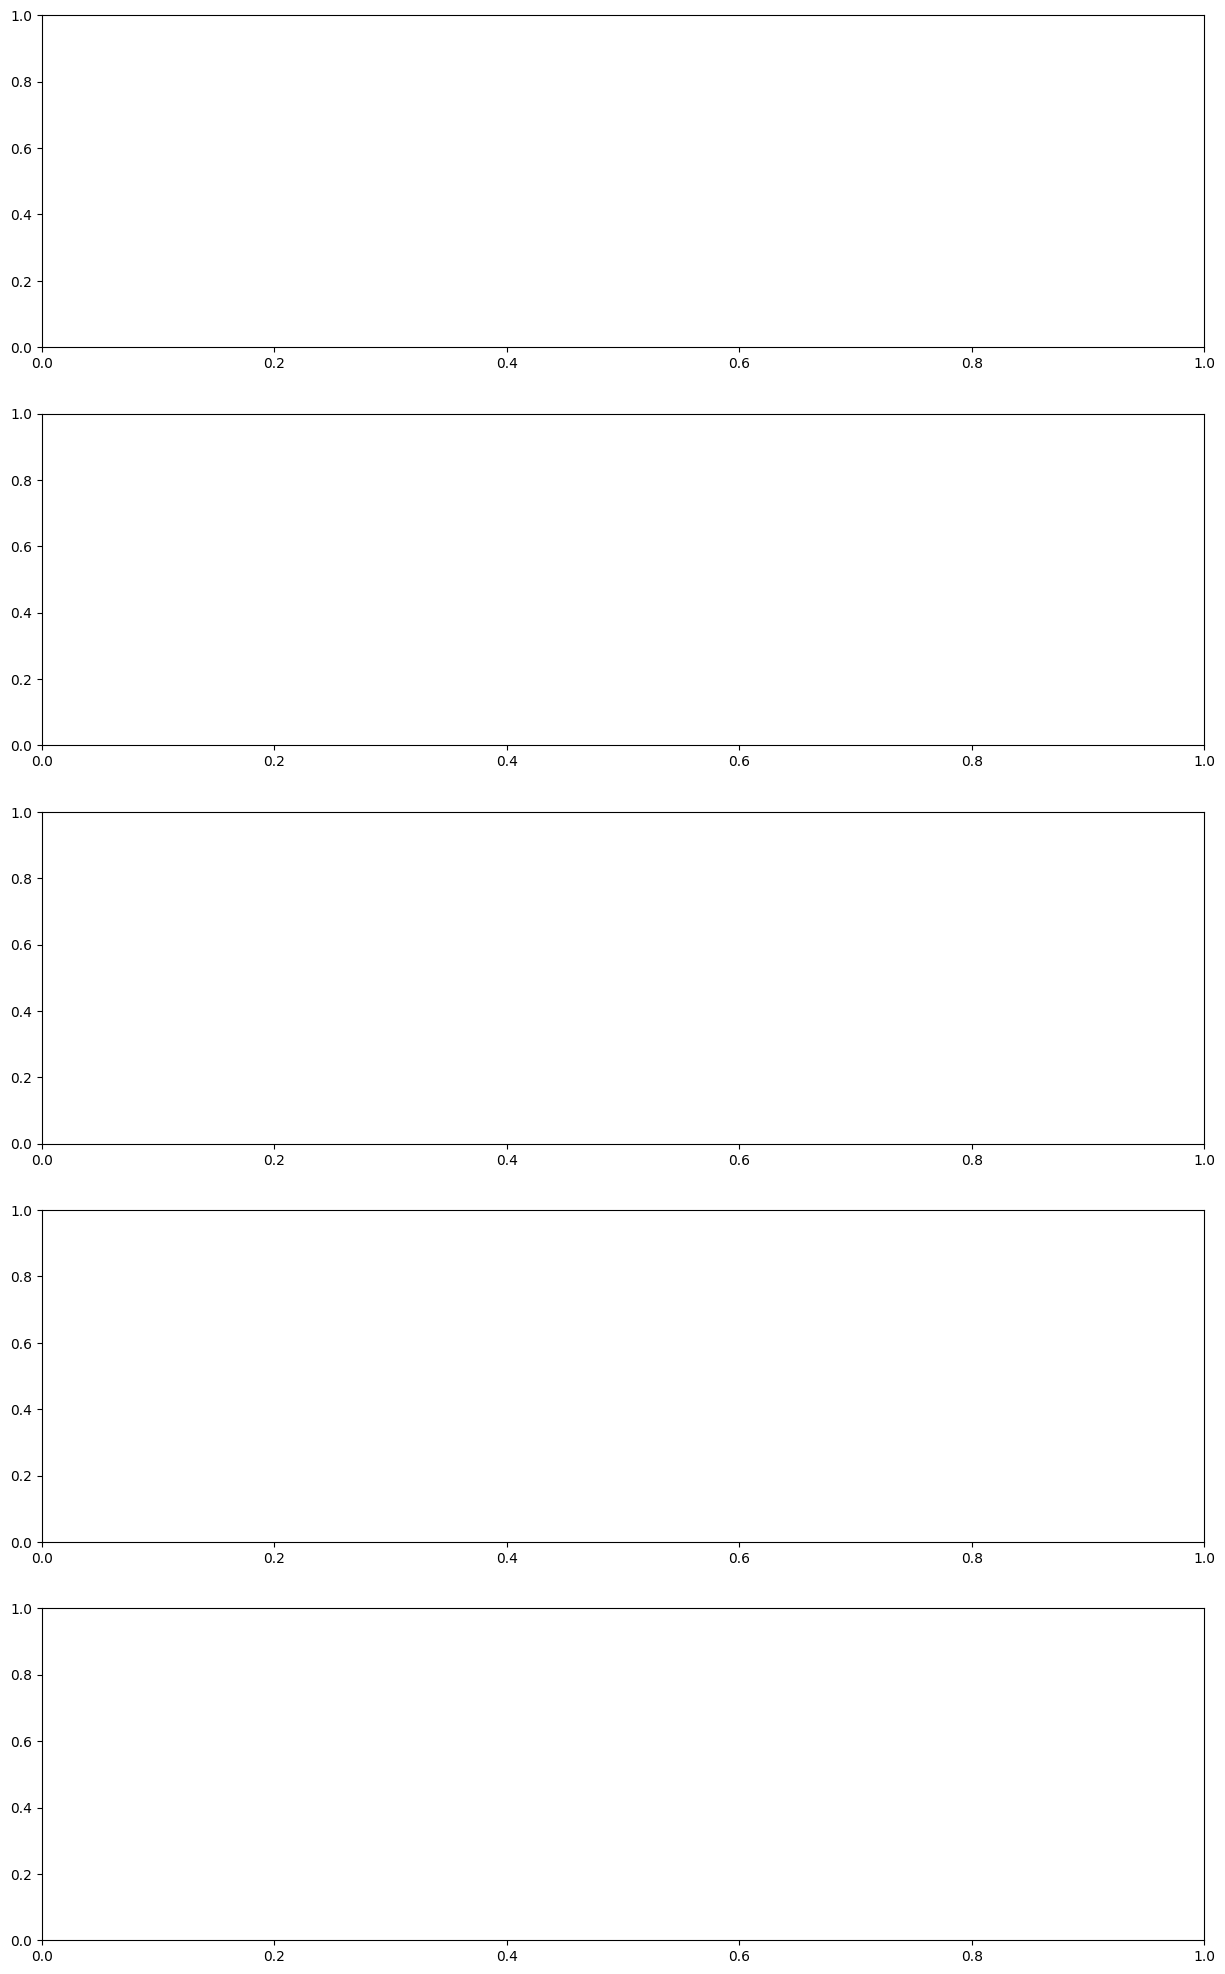

In [11]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))
for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')


